In [21]:
import torch 
import torchvision 
import onnx 
import onnxruntime 
import numpy as np 
import matplotlib.pyplot as plt


In [22]:
# load model from torchvision 
model = torchvision.models.shufflenet_v2_x0_5(pretrained=True) 
print(model)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

In [77]:
fake_input = torch.randn([1,3,224,224])
onnx_name = 'shuffleNet-0.5.onnx'
torch.onnx.export(model,(fake_input),onnx_name,verbose=True,input_names=['input_images'],output_names=['outputs'])

s/torchvision/models/shufflenetv2.py:28:0
  %459 : Tensor = onnx::Constant[value=  1  -1  14  14 [ CPULongType{4} ]]()
  %460 : Float(1:18816, 96:196, 14:14, 14:1, requires_grad=1, device=cpu) = onnx::Reshape(%458, %459) # /home/altex/torch-venv/lib/python3.8/site-packages/torchvision/models/shufflenetv2.py:31:0
  %461 : Float(1:18816, 48:196, 14:14, 14:1, requires_grad=1, device=cpu), %462 : Float(1:18816, 48:196, 14:14, 14:1, requires_grad=1, device=cpu) = onnx::Split[axis=1, split=[48, 48]](%460)
  %691 : Float(1:9408, 48:196, 14:14, 14:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%462, %692, %693)
  %465 : Float(1:9408, 48:196, 14:14, 14:1, requires_grad=1, device=cpu) = onnx::Relu(%691) # /home/altex/torch-venv/lib/python3.8/site-packages/torch/nn/functional.py:1134:0
  %694 : Float(1:9408, 48:196, 14:14, 14:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=48, kernel_shape=[3, 3]

# Check graph

In [78]:
import onnx
onnx_model = onnx.load(onnx_name)
onnx.checker.check_model(onnx_model)

# onnx runtime

In [79]:
sess = onnxruntime.InferenceSession(onnx_name) 

### get inputs:

In [80]:
input_names = [inp.name for inp in sess.get_inputs()]
print(input_names)

['input_images']


In [81]:
# get input 0 for instance
inp0 = sess.get_inputs()[0]
print('name: ', inp0.name)
print('shape: ',inp0.shape)
print('type: ',inp0.type)


name:  input_images
shape:  [1, 3, 224, 224]
type:  tensor(float)


### Get outputs:

In [82]:
output_names = [outp.name for outp in sess.get_outputs()]
print(output_names)

['outputs']


In [83]:
# get output 0 for instance
outp0 = sess.get_outputs()[0]
print('name: ', outp0.name)
print('shape: ',outp0.shape)
print('type: ',outp0.type)

name:  outputs
shape:  [1, 1000]
type:  tensor(float)


(640, 586, 3)
(224, 224, 3)


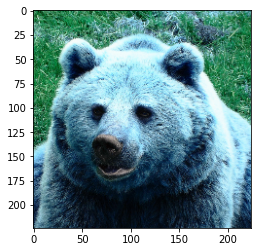

In [84]:
import cv2
img = cv2.imread('/home/altex/sample.jpg')
print(img.shape)
img = cv2.resize(img,(224,224))
print(img.shape)
plt.imshow(img) 

In [85]:
import numpy as np 
def preprocess(img):        
    img_ = np.transpose(img,[2,0,1])
    img_ = np.reshape(img_,[1]+list(img_.shape))
    img_ = np.float32(img_)/255.
    return img_ 
img1 = preprocess(img)
input_tensor = torch.from_numpy(img1) 
print(input_tensor.size())
model.eval()
torch_output = model(input_tensor).detach().numpy()

torch.Size([1, 3, 224, 224])


In [86]:
onnx_output = sess.run(output_names, {input_names[0]:img1})

In [87]:
print(onnx_output[0].shape)
print(torch_output.shape)

(1, 1000)
(1, 1000)


In [88]:
np.testing.assert_allclose(torch_output, onnx_output[0], rtol=1e-03, atol=1e-05)

### Dynamic batch:
for dynamic batch inference we need to specify dynamic dimension at exporting stage:

In [128]:
batch_size = 1
fake_input = torch.randn(batch_size,3,224,224)
onnx_name_ = 'shuffleNet-0.5_.onnx'
torch.onnx.export(model,(fake_input),onnx_name_,verbose=False,input_names=['input_images'],
opset_version=11,  do_constant_folding=True,output_names=['outputs'],
dynamic_axes={'input_images' : {0 : 'batch_size'},    # variable lenght axes
                                'outputs' : {0 : 'batch_size'}})
import onnx
onnx_model = onnx.load(onnx_name_)
onnx.checker.check_model(onnx_model)

In [129]:
new_sess = onnxruntime.InferenceSession(onnx_name_) 

In [130]:
img1 = preprocess(img)
img2 = preprocess(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
imgs = np.concatenate([img1, img2],0)
print(imgs.shape)
input_tensor = torch.from_numpy(imgs) 
print(input_tensor.size())
model.eval()
torch_output = model(input_tensor).detach().numpy()

(2, 3, 224, 224)
torch.Size([2, 3, 224, 224])


In [131]:
onnx_output = new_sess.run(output_names, {input_names[0]:imgs})

RuntimeException: [ONNXRuntimeError] : 6 : RUNTIME_EXCEPTION : Non-zero status code returned while running Reshape node. Name:'Reshape_13' Status Message: /onnxruntime_src/onnxruntime/core/providers/cpu/tensor/reshape_helper.h:43 onnxruntime::ReshapeHelper::ReshapeHelper(const onnxruntime::TensorShape&, std::vector<long int>&) gsl::narrow_cast<int64_t>(input_shape.Size()) == size was false. The input tensor cannot be reshaped to the requested shape. Input shape:{2,48,28,28}, requested shape:{1,2,24,28,28}


In [113]:
np.testing.assert_allclose(torch_output, onnx_output[0], rtol=1e-03, atol=1e-05)

# Visualize graph

In [132]:
# Print a human readable representation of the graph
onnx_model = onnx.load(onnx_name)
onnx.helper.printable_graph(onnx_model.graph)

'graph torch-jit-export (\n  %input_images[FLOAT, batch_sizex3x224x224]\n) initializers (\n  %614[FLOAT, 24x3x3x3]\n  %615[FLOAT, 24]\n  %617[FLOAT, 24x1x3x3]\n  %618[FLOAT, 24]\n  %620[FLOAT, 24x24x1x1]\n  %621[FLOAT, 24]\n  %623[FLOAT, 24x24x1x1]\n  %624[FLOAT, 24]\n  %626[FLOAT, 24x1x3x3]\n  %627[FLOAT, 24]\n  %629[FLOAT, 24x24x1x1]\n  %630[FLOAT, 24]\n  %632[FLOAT, 24x24x1x1]\n  %633[FLOAT, 24]\n  %635[FLOAT, 24x1x3x3]\n  %636[FLOAT, 24]\n  %638[FLOAT, 24x24x1x1]\n  %639[FLOAT, 24]\n  %641[FLOAT, 24x24x1x1]\n  %642[FLOAT, 24]\n  %644[FLOAT, 24x1x3x3]\n  %645[FLOAT, 24]\n  %647[FLOAT, 24x24x1x1]\n  %648[FLOAT, 24]\n  %650[FLOAT, 24x24x1x1]\n  %651[FLOAT, 24]\n  %653[FLOAT, 24x1x3x3]\n  %654[FLOAT, 24]\n  %656[FLOAT, 24x24x1x1]\n  %657[FLOAT, 24]\n  %659[FLOAT, 48x1x3x3]\n  %660[FLOAT, 48]\n  %662[FLOAT, 48x48x1x1]\n  %663[FLOAT, 48]\n  %665[FLOAT, 48x48x1x1]\n  %666[FLOAT, 48]\n  %668[FLOAT, 48x1x3x3]\n  %669[FLOAT, 48]\n  %671[FLOAT, 48x48x1x1]\n  %672[FLOAT, 48]\n  %674[FLOAT, 48x

(-0.5, 4714.5, 32766.5, -0.5)

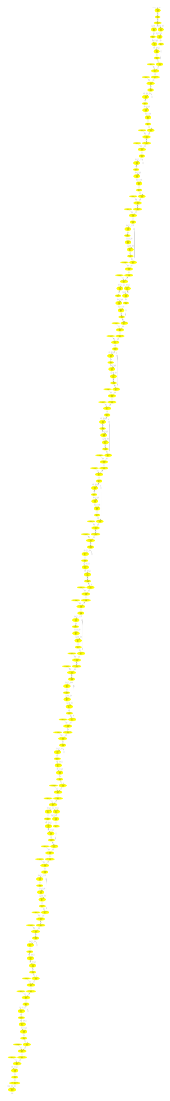

In [31]:
from onnx import helper, TensorProto, checker
from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer
onnx_model = onnx.load(onnx_name)
pydot_graph = GetPydotGraph(
    onnx_model.graph, name=onnx_model.graph.name, rankdir="TB",
    node_producer=GetOpNodeProducer("docstring", color="yellow",
                                    fillcolor="yellow", style="filled"))
pydot_graph.write_dot("pipeline_transpose2x.dot")

os.system('dot -O -Gdpi=300 -Tpng pipeline_transpose2x.dot')

image = plt.imread("pipeline_transpose2x.dot.png")
fig, ax = plt.subplots(figsize=(40, 20))
ax.imshow(image)
ax.axis('off')